# Anomaly Detection using STL
## STL: Seasonal-Trend Decomposition using LOESS
### LOESS: LOcally wEighted Scatterplot Smoothing
Sources: [GitHub repo](https://github.com/ritvikmath/Time-Series-Analysis/blob/master/STL%20Decomposition.ipynb) and [YouTube video](https://www.youtube.com/watch?v=1NXryMoU7Ho&list=LL&index=10)    
Feb 17th 2023

In [1]:
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import pmdarima as pm
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plotsize = (22, 5)
plt.rcParams['figure.figsize']= plotsize
# Pandas config
pd.options.display.float_format= '{:,.4f}'.format

In [3]:
print(os.getcwd())

/home/razielar/Documents/git_rep/Machine_learning/time_series_forecasting/coursera_time_series_forecasting/anomaly_detection


## 0) Functions

In [4]:
def eda_plots(data, lags= None, save= False, save_path= ''):
    plt.rcParams['figure.figsize']= (22,5)
    layout= (1,3)
    raw= plt.subplot2grid(layout, (0,0))
    pacf= plt.subplot2grid(layout, (0,1))
    acf= plt.subplot2grid(layout, (0,2))
    
    raw.plot(data)
    plot_acf(data, lags= lags, ax= acf, zero= False)
    plot_pacf(data, lags= lags, ax= pacf, zero= False)
    plt.tight_layout()
    if save:
        plt.savefig(save_path, transparent= True)

def future_preds_df(model,series,num_months):
    """
    Generate a df with model predictions
    """
    pred_first = series.index.max()+relativedelta(months=1)
    pred_last = series.index.max()+relativedelta(months=num_months)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'MS')
    vals = model.predict(n_periods = num_months)
    return pd.DataFrame(vals,index = date_range_index)

def mape(y: pd.Series, y_hat: pd.Series) -> np.float64:
    """
    Implements Mean Absolute Percent Error (MAPE).
    Args:
        y: actual values.
        y_hat: predicted values.
    Returns:
        MAPE value (Not in %)
    """
    if not (isinstance(y, pd.Series) and isinstance(y_hat, pd.Series)):
        y, y_hat = pd.Series(y), pd.Series(y_hat)
    mape = np.mean( np.abs( (y-y_hat)/y ) )
    return np.round(mape, 4)

## 1) Input Data

In [5]:
filePath = "data/ice_cream_interest.csv"
df = pd.read_csv(filePath, parse_dates= ["month"])
df

,month,interest
0,2004-01-01,13
1,2004-02-01,15
2,2004-03-01,17
3,2004-04-01,19
4,2004-05-01,22
...,...,...
195,2020-04-01,55
196,2020-05-01,71
197,2020-06-01,81
198,2020-07-01,90


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   month     200 non-null    datetime64[ns]
 1   interest  200 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.2 KB


## 2) PreProcessing

In [7]:
df.set_index("month", inplace= True)
df

,interest
month,
2004-01-01,13
2004-02-01,15
2004-03-01,17
2004-04-01,19
2004-05-01,22
...,...
2020-04-01,55
2020-05-01,71
2020-06-01,81


`MS` = MonthBegin, the description is located [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

In [8]:
df = df.asfreq(pd.infer_freq(df.index))
df

,interest
month,
2004-01-01,13
2004-02-01,15
2004-03-01,17
2004-04-01,19
2004-05-01,22
...,...
2020-04-01,55
2020-05-01,71
2020-06-01,81


## 3) EDA

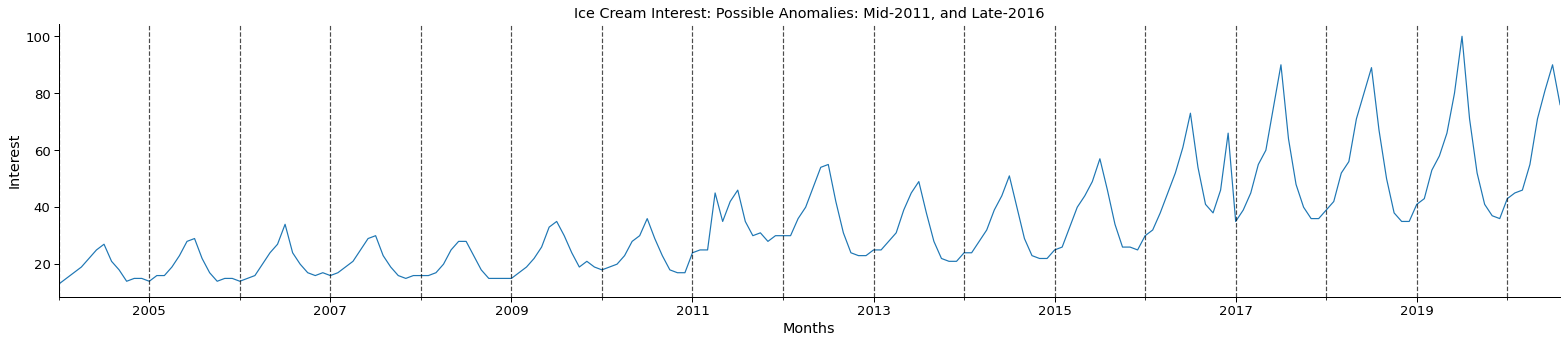

In [9]:
df["interest"].plot()
# Add vertical lines at each year to better visualize the yearly seasonality
for i in range(2004,2021):
    plt.axvline(datetime(i,1,1), color='k', linestyle='--', alpha=0.7)

plt.title("Ice Cream Interest: Possible Anomalies: Mid-2011, and Late-2016")
plt.ylabel("Interest")
plt.xlabel("Months")
plt.tight_layout()

## 4) STL

In [10]:
stl = STL(df)
result = stl.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid

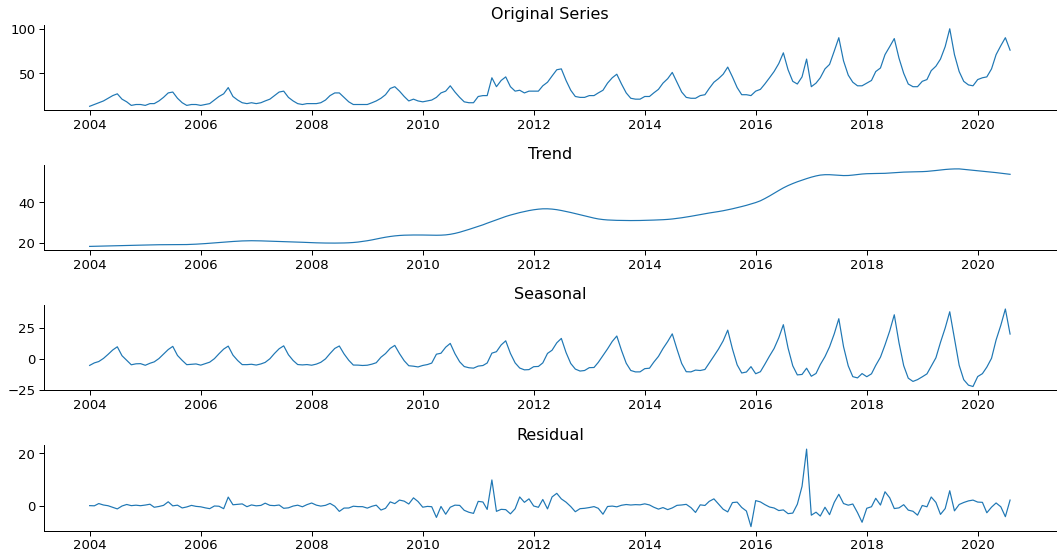

In [11]:
plt.figure(figsize=(15,8))

plt.subplot(4,1,1)
plt.plot(df)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

## 5) Series vs. Estimated

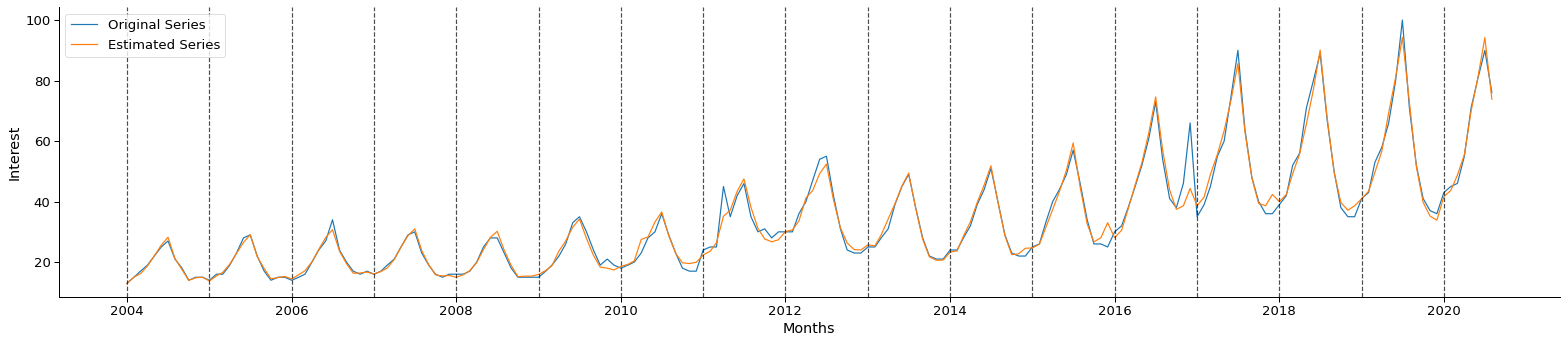

In [12]:
estimated = trend + seasonal
plt.plot(df, label= "Original Series")
plt.plot(estimated, label= "Estimated Series")
# Add vertical lines at each year to better visualize the yearly seasonality
for i in range(2004,2021):
    plt.axvline(datetime(i,1,1), color='k', linestyle='--', alpha=0.7)
plt.ylabel("Interest")
plt.xlabel("Months")    
plt.legend(loc= "upper left")
plt.tight_layout()

## 6) Anomaly Detection

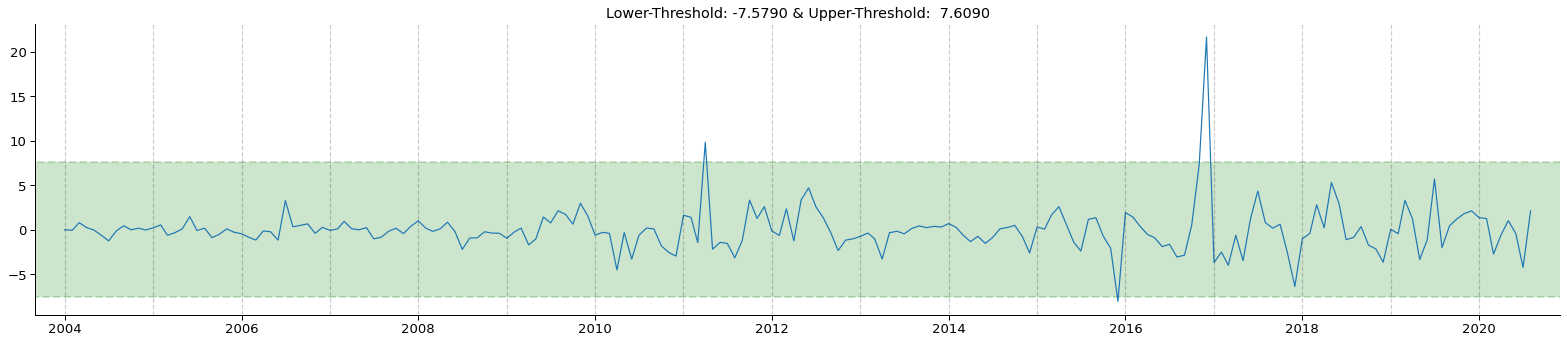

In [13]:
# Define series cutoffs:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

plt.plot(resid)
plt.fill_between([datetime(2003,1,1), datetime(2021,8,1)], lower, upper, alpha= 0.20, color= "g", linestyle= "dashed", linewidth=2)
# For better plotting
plt.xlim(datetime(2003,9,1), datetime(2020,12,1))
for i in range(2004,2021):
    plt.axvline(datetime(i,1,1), color='k', linestyle='--', alpha=0.2)

plt.title(f"Lower-Threshold: {lower: .4f} & Upper-Threshold: {upper: .4f}")    
plt.tight_layout()

In [14]:
# Highlight date anomalies
anomalies = df[(resid < lower) | (resid > upper)]
anomalies

,interest
month,
2011-04-01,45
2015-12-01,25
2016-12-01,66


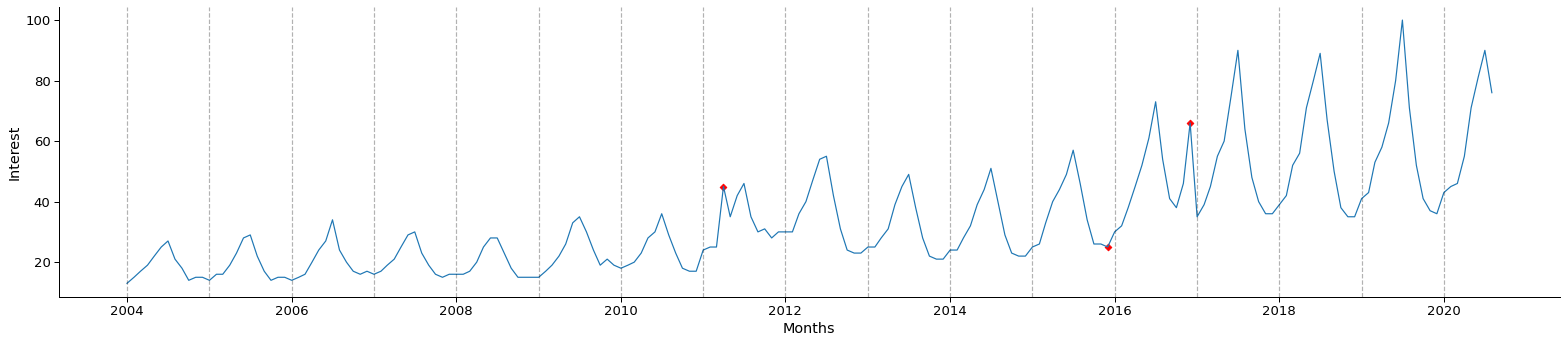

In [15]:
plt.plot(df)
for i in range(2004,2021):
    plt.axvline(datetime(i,1,1), color='k', linestyle='--', alpha=0.3)

# Plot anomalies:
plt.scatter(anomalies.index, anomalies.interest, color='r', marker='D')
plt.ylabel("Interest")
plt.xlabel("Months")
plt.tight_layout()

In [16]:
# The highest anamaly is at: 2016-12-01, let see the previous days
df[df.index.month == 12]

,interest
month,
2004-12-01,15
2005-12-01,15
2006-12-01,17
2007-12-01,16
2008-12-01,15
2009-12-01,19
2010-12-01,17
2011-12-01,30
2012-12-01,23


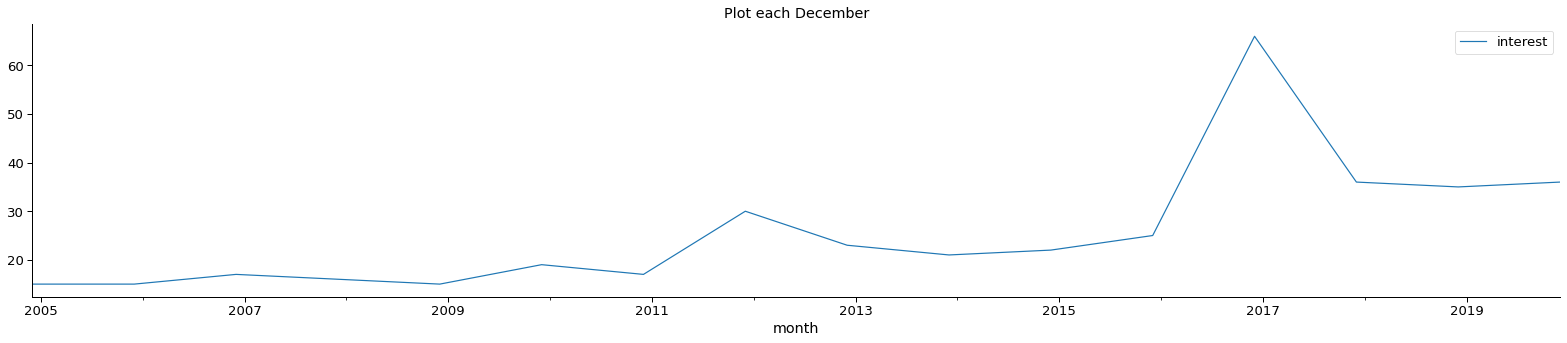

In [17]:
df[df.index.month == 12].plot()
plt.title("Plot each December")
plt.tight_layout()

## 7) Train, Test split 

In [18]:
# We're going to set 6 months for test
months_num = 6
train, test = train_test_split(df, test_size=months_num, shuffle=False)

## 8) Forecast: Raw Data

### 8.1) EDA of Training data

/home/razielar/miniconda3/envs/time-series/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


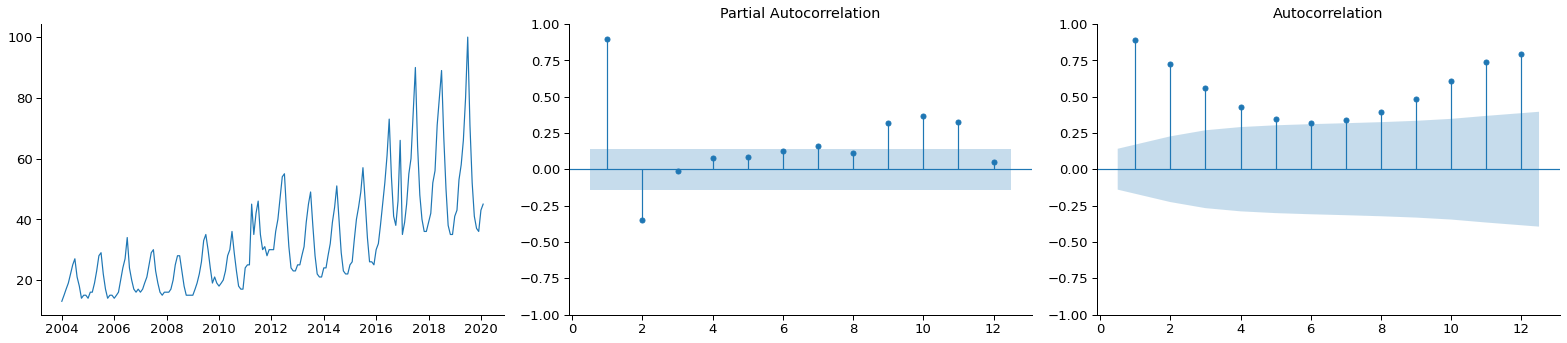

In [19]:
eda_plots(train, lags= 12)

### 8.2) SARIMA model for Raw data

In [20]:
%%time
stepwise_model = pm.auto_arima(train, 
                               start_p=0, max_p= 3,
                               d= 0, 
                               start_q=0, max_q= 3,
                               m=12, seasonal=True,
                               start_P=0, max_P= 3,
                               D=1, 
                               start_Q= 0, max_Q= 3,
                               trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

print('')
print('-'*28)
print("A|C: {:.3f}\np,d,q: {}\nP,D,Q: {}".format(stepwise_model.aic(), stepwise_model.order, stepwise_model.seasonal_order)) 

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1194.926, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1090.664, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1125.662, Time=0.32 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1219.582, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1119.022, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1084.666, Time=0.76 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1079.039, Time=1.90 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1079.227, Time=2.62 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1079.971, Time=1.47 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=1185.338, Time=1.55 sec
 ARIMA(2,0,0)(3,1,0)[12] intercept   : AIC=1077.104, Time=2.36 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1081.409, Time=1.00 sec
 ARIMA(2,0,0)(3,1,1)[12] intercept   : AIC=1078.042, Time=2.50 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=1078.466, Time=1.06 sec
 ARIMA(3,0,0)(3,1,0

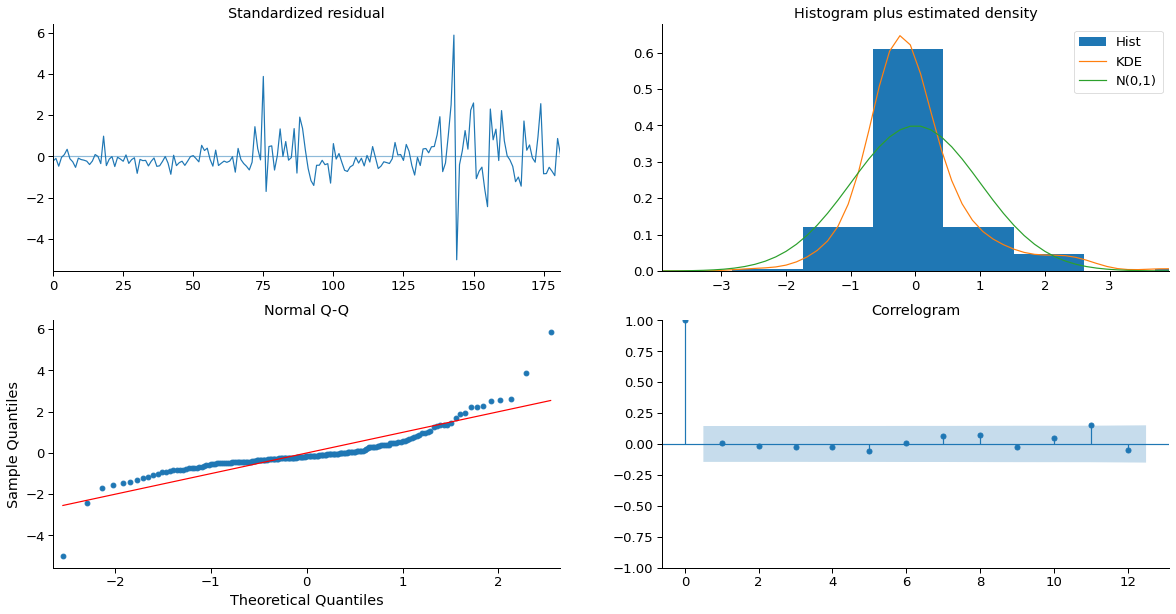

In [21]:
stepwise_diag = stepwise_model.plot_diagnostics(lags=12, figsize= (20,10))

In [22]:
sarima_predictions_raw_data = future_preds_df(model= stepwise_model, series= train, num_months= months_num)
sarima_predictions_raw_data.rename(columns= {0: "forecast"}, inplace= True)
sarima_predictions_raw_data

,forecast
2020-03-01,53.6751
2020-04-01,59.4847
2020-05-01,68.6363
2020-06-01,80.5405
2020-07-01,95.7584
2020-08-01,70.9212


### 8.3) Raw Forecast Result

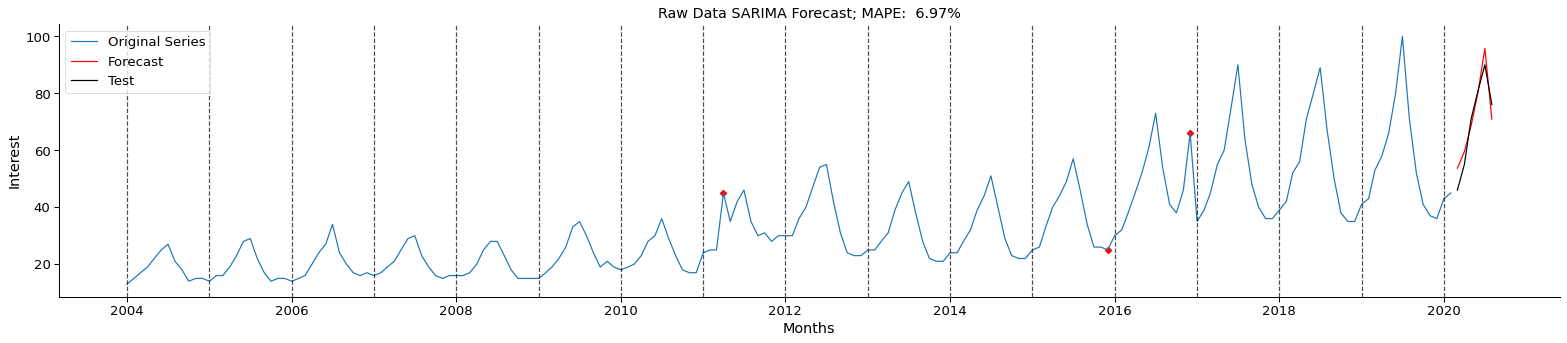

In [82]:
plt.plot(train, label= "Original Series")
plt.plot(sarima_predictions_raw_data, color= "r", label= "Forecast")
plt.plot(test, color= "black", label= "Test")
plt.scatter(anomalies.index, anomalies.interest, color='r', marker='D')

for i in range(2004,2021):
    plt.axvline(datetime(i,1,1), color='k', linestyle='--', alpha=0.7)
    
# Calculate MAPE:
raw_mape = mape(y= test.interest, y_hat= sarima_predictions_raw_data.forecast)

plt.ylabel("Interest")
plt.xlabel("Months")
plt.legend(loc= "upper left")
plt.title(f"Raw Data SARIMA Forecast; MAPE: {raw_mape: 0.2%}")
plt.tight_layout()

## 9) Forecast with Anomalies fixed
What to do about the anamaly?
* Simple idea: use mean of other months

In [38]:
adjusted_data = train.copy(deep= True)
adjusted_data

,interest
month,
2004-01-01,13
2004-02-01,15
2004-03-01,17
2004-04-01,19
2004-05-01,22
...,...
2019-10-01,41
2019-11-01,37
2019-12-01,36


We have anamalies at December and at April

In [39]:
december_data = df[df.index.month == 12]
april_data = df[df.index.month == 4]

# Replace April Anomalies
adjusted_data.loc[anomalies.index[0]] = april_data[april_data.index != anomalies.index[0]].mean()
# Replace December Anomalies
december_replace_value = december_data[~december_data.index.isin(anomalies.index[1:3])].mean()

adjusted_data.loc[anomalies.index[1]] = december_replace_value
adjusted_data.loc[anomalies.index[2]] = december_replace_value

# Confirm 
adjusted_data.loc[anomalies.index]

,interest
month,
2011-04-01,34.7500
2015-12-01,22.6429
2016-12-01,22.6429


In [40]:
anomalies

,interest
month,
2011-04-01,45
2015-12-01,25
2016-12-01,66


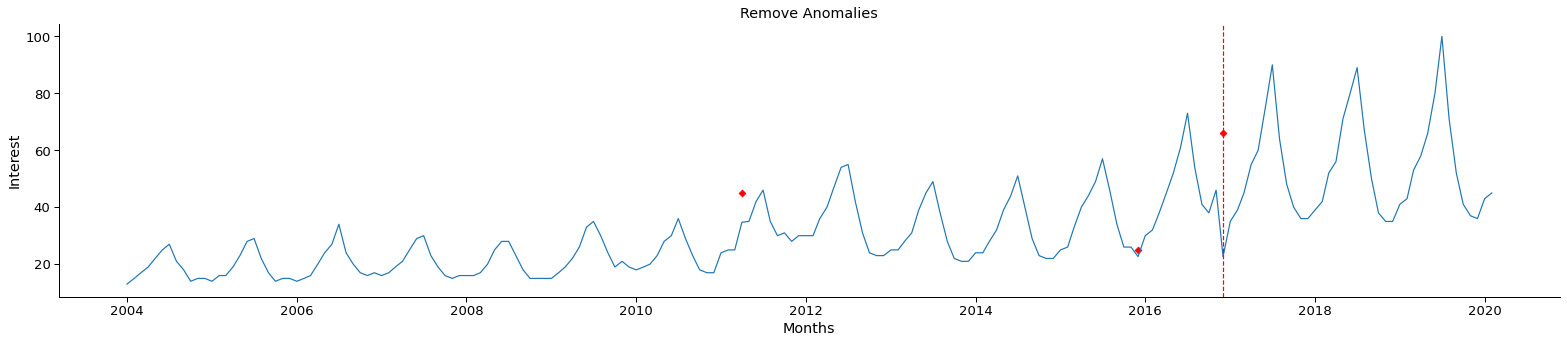

In [53]:
plt.plot(adjusted_data)
plt.scatter(anomalies.index, anomalies.interest, color='r', marker='D')
plt.axvline(x= datetime(2016, 12, 1), color= "r", linestyle= "dashed")

# for i in range(2004,2021):
#     plt.axvline(datetime(i,1,1), color='k', linestyle='--', alpha=0.7)

plt.title("Remove Anomalies")
plt.ylabel("Interest")
plt.xlabel("Months")    
plt.tight_layout()

### 9.1) EDA of Adjusted Data

/home/razielar/miniconda3/envs/time-series/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


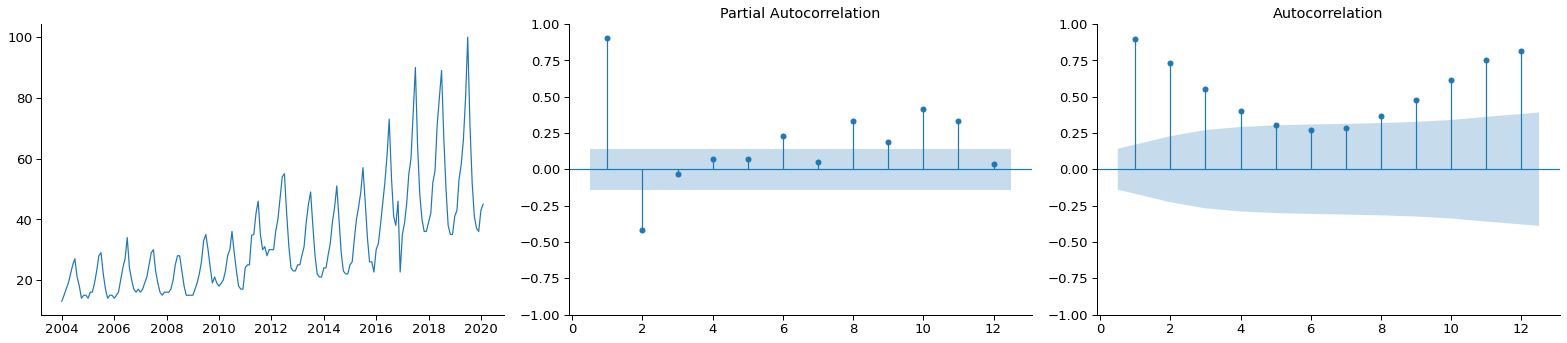

In [54]:
eda_plots(adjusted_data, lags= 12)

### 9.2) SARIMA model for Adjusted data

In [57]:
%%time
stepwise_model_adjusted_data = pm.auto_arima(adjusted_data, 
                               start_p=0, max_p= 3,
                               d= 0, 
                               start_q=0, max_q= 3,
                               m=12, seasonal=True,
                               start_P=0, max_P= 3,
                               D=1, 
                               start_Q= 0, max_Q= 3,
                               trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

print('')
print('-'*28)
print("A|C: {:.3f}\np,d,q: {}\nP,D,Q: {}".format(stepwise_model_adjusted_data.aic(), 
                                                 stepwise_model_adjusted_data.order, 
                                                 stepwise_model_adjusted_data.seasonal_order)) 

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1110.237, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=978.223, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1032.479, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1149.022, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=997.545, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=974.426, Time=0.73 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=975.365, Time=1.37 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=975.463, Time=0.81 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=973.787, Time=0.31 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=971.791, Time=0.20 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=973.787, Time=0.65 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=975.741, Time=1.69 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1112.065, Time=0.14 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=967.380, Time=0.35 sec
 ARIMA(2,0,0)(0,1,0)[12] inte

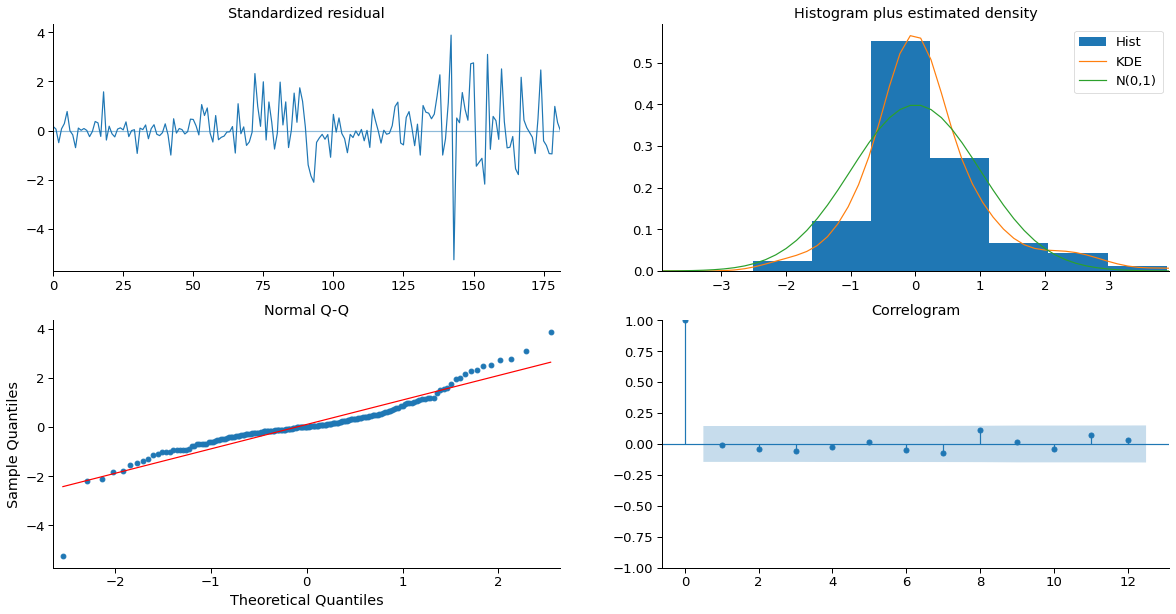

In [59]:
stepwise_model_adjusted_data_dignostic_plot = stepwise_model_adjusted_data.plot_diagnostics(lags= 12, figsize= (20,10))

In [62]:
sarima_predictions_adjusted_data = future_preds_df(model= stepwise_model_adjusted_data, series= adjusted_data, num_months= months_num)
sarima_predictions_adjusted_data.rename(columns= {0: "forecast_adjustedData"}, inplace= True)
sarima_predictions_adjusted_data

,forecast_adjustedData
2020-03-01,56.0255
2020-04-01,61.6167
2020-05-01,71.7953
2020-06-01,85.2266
2020-07-01,102.3553
2020-08-01,74.0053


### 9.3) Forecast with Adjusted Data

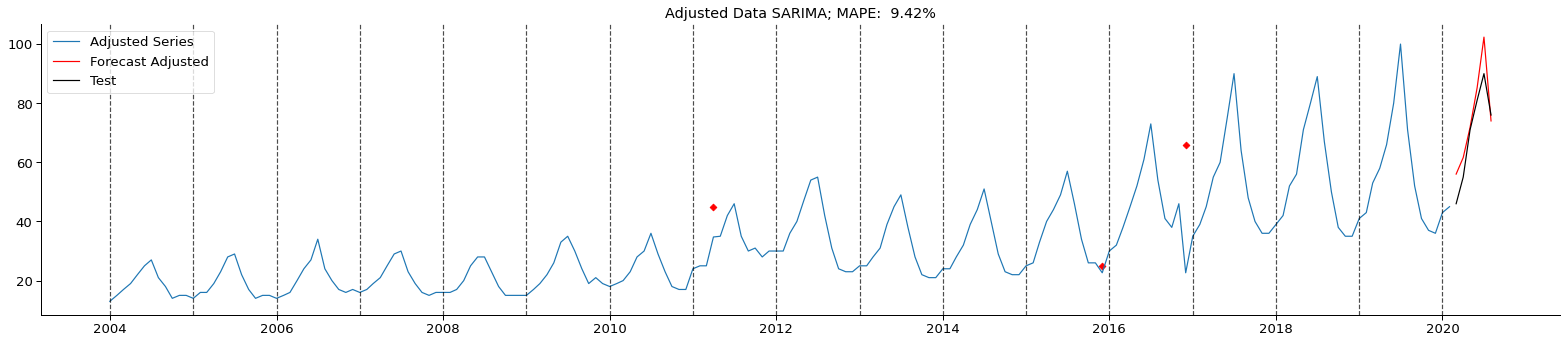

In [81]:
plt.plot(adjusted_data, label= "Adjusted Series")
plt.plot(sarima_predictions_adjusted_data, color= "r", label= "Forecast Adjusted")
plt.plot(test, color= "black", label= "Test")
plt.scatter(anomalies.index, anomalies.interest, color='r', marker='D')

# Calculate MAPE:
adjusted_mape = mape(y= test.interest, y_hat= sarima_predictions_adjusted_data.forecast_adjustedData)

for i in range(2004,2021):
    plt.axvline(datetime(i,1,1), color='k', linestyle='--', alpha=0.7)

plt.legend(loc= "upper left")    
plt.title(f"Adjusted Data SARIMA; MAPE: {adjusted_mape: 0.2%}")
plt.tight_layout()